In [1]:
# -*- coding: utf-8 -*-
#  Copyright 2025 Technical University of Denmark
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#  Authored by: Rafael Flock (DTU)
#  Edited by: Chao Zhang (DTU)
#  Reviewed by: Jakob Sauer Jørgensen (DTU)

# Certified coordinate selection for high-dimensional Bayesian inversion with Laplace prior

### Rafael Flock (raff@dtu.dk)

This notebook demonstrates the use of the certified coordinate selection (CCS) method proposed in

[1] _Flock, Rafael, Yiqiu Dong, Felipe Uribe, and Olivier Zahm. “Certified Coordinate Selection for High-Dimensional Bayesian Inversion with Laplace Prior.” Statistics and Computing 34, no. 4 (2024): 134. https://doi.org/10.1007/s11222-024-10445-1._

CCS considers high-dimensional Bayesian inverse problems with product-form Laplace priors. The method proposes an approximate posterior by applying a gradient-based diagnostic to identify coordinates that contribute most to the update from the prior to the posterior. Afterwards, the approximate posterior can efficiently be inferred with Markov chain Monte Carlo (MCMC) methods on a lower dimensional space, since most of its coordinates are only informed by the prior.

We start by importing the necessary libraries.

In [2]:
import numpy as np
from scipy.ndimage import gaussian_filter1d
import pywt
import matplotlib.pyplot as plt
from pathlib import PurePath, Path

from cuqi.model import LinearModel
from cuqi.distribution import JointDistribution, Gaussian, SmoothedLaplace
from cuqi.experimental.mcmc import MALA
from cuqi import samples
import cuqi

from utils import *

print(cuqi.__version__)

1.3.0


For the convenience of configuration, we collect all parameters to be used here.

In [3]:
# ground truth and MAP of coefficients files
true_signal_file = PurePath(r'oneD_pw_const_1022.npy')

# noise (additive Gaussian)
noise_seed = 0
noise_std = 3e-2

# blurring
blur_r = 12 # radius
blur_std = 6
blur_BC = 'constant' # 0 BCs

# wavelet
wavelet = 'haar'
wavelet_BC = 'constant' # same as blur_BC 

# sampling
N_po = 5_000 # number of posterior samples
N_b = 20_000 # burn-in
th = 50 # thinning quotient
r = 100 # number of selected coordinates

## 1. Problem setting

The problem under consideration is the following:
$$y = Gs + e.$$
$G$ is a convolution operator with a Gaussian kernel, $s$ is the signal to recover, and $e$ is Gaussian measurement noise. We apply the wavelet inverse transform $W$ to represent the signal in the domain of wavelet coefficients, i.e., $s=Wx$. Particularly, we choose a 10-level Haar wavelet with zero boundary conditions. With this wavelet transform, we can rewrite the problem as
$$y = GWx + e.$$
For brevity, in the following we write $A:= GW$.

When chosing an appropriate basis, we expect most of the wavelet coefficients $x$ to be close to zero. Therefore, we apply a product-form Laplace prior on $x$. Thus, we obtain the following _synthesis_ formulation of the posterior w.r.t. the wavelet coefficients $x$
$$
\pi(x|y) \propto \exp( -\frac{\lambda}{2} \| y - A x \|_2^2 ) \exp(-\sum_i^d \delta_i |x_i|),
$$
where $\delta_i>0$ for $i=1,2,\dots d$ are the rate parameters.

In [4]:
# blur
G = lambda x: gaussian_filter1d(input=x, sigma=blur_std, mode=blur_BC, radius=blur_r)

# wavelet synthesis operator
s_true = np.load(Path(true_signal_file))
coeffs = pywt.wavedec(s_true, wavelet, wavelet_BC)   
x_true, coeff_slices, coeff_shapes = pywt.ravel_coeffs(coeffs)
d = x_true.size
W = lambda x: pywt.waverec(pywt.unravel_coeffs(x, coeff_slices, coeff_shapes, 'wavedec'), wavelet, wavelet_BC)

A = lambda x: G(W(x))

Note that we chose different rate parameters $\delta_i$ in the Laplace prior based on the level of each wavelet coefficient $x_i$. To this end, we exploit the fact that our product-form Laplace prior corresponds to a Besov-1-1 prior for which the rate parameters are computed as follows.

In [5]:
delta_f = lambda l: 2**(1/2*l) # 2^(l* (s+d/2-d/p) ) where: l level, d (geometric dimension) = 1, p=s=1 
delta = np.zeros(d, dtype=np.double)
for ii in range(len(coeff_slices)):
    if ii == 0: delta[coeff_slices[0]] = delta_f(0) # approximation coefficients scaled by 1
    else: delta[coeff_slices[ii]['d']] = delta_f(ii-1)

We now compute the synthetic data. First, we import the ground truth signal `x_true` from an external .npy file and apply the convolution operator $G$ to it to obtain `y_true`. Afterwards, we obtain the data `y` by adding Gaussian noise to `y_true`.

In [6]:
s_true = np.load(Path(true_signal_file))
y_true = G(s_true)
np.random.seed(noise_seed)
y = y_true + np.random.normal(scale=noise_std, size=y_true.size)
noise_level = noise_std / np.linalg.norm(y_true) * np.sqrt( y_true.size )
lam = 1/noise_std**2 # precision (inverse variance) of noise

To identify the most important wavelet coefficients in the dimension reduction later, we need to find the maximum-a-posteriori probability estimate.

We can compute it as 
$$
x_\mathrm{MAP} = \underset{x}{\text{argmin}} \frac{\lambda}{2} \| y - A x \|_2^2 + \sum_i^d \delta_i |x_i|.
$$
Since this is a convex problem, we can efficiently compute the solution via convex optimization toolboxes as for example `cvxpy`.
We don't perform this computation here and just load the solution in the next cell.

We conclude this section with a plot of the true signal in signal space.

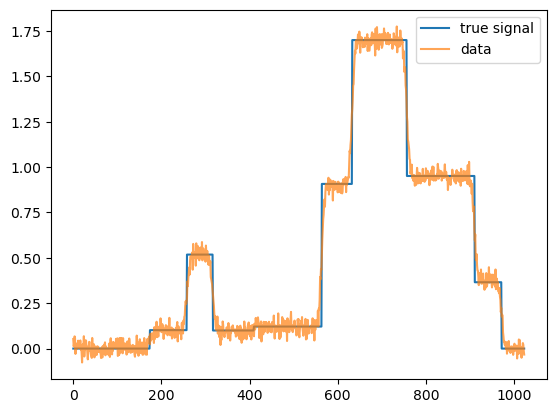

In [7]:
plt.plot(s_true, label='true signal')
plt.plot(y, label='data', alpha=0.7)
plt.legend()

## 2. Reference solution

### 2.1 Smoothed Laplace prior

In this notebook, we use MALA for sampling. Since MALA requires gradients of the log target density, we will in fact not sample the exact posterior but a smoothed version. However, as long as the approximation parameter (see below) is chosen small enough, the exact posterior and the approximation are very similar in praxis.

The smoothed posterior is obtained by smoothing the prior as 
$$
\pi_\varepsilon(x) \propto \exp(-\sum_{i=1}^d \delta_i \sqrt{x_i^2+\varepsilon})
$$
with some small $0 < \varepsilon$, and we denote the resulting posterior as $\pi_\varepsilon(x|y)$. The smoothed Laplace distribution is implemented in CUQIpy as `SmoothedLaplace`. Moreover, we chose $\varepsilon=10^{-8}$ to be close to the exact prior.

In [8]:
X = SmoothedLaplace(np.zeros(d), 1/delta, beta=1e-8)

### 2.2 Likelihood

Since we are working with the linear operator $A=GW$, we need to define a `LinearModel` before constructing the likelihood function. To this end, we require the adjoint operator $A^*$. In our case, we have $G^T=G$, and since we use the ortogonal Haar wavelet with zero BCs, $W^T=W^{-1}$. Therefore, $A^*=W^{-1}G$.

In [9]:
# adjoint of forward operator
W_inv = lambda s: pywt.ravel_coeffs(pywt.wavedec(s, wavelet, wavelet_BC))[0]   
A_adj = lambda y: W_inv(G(y))

# set up cuqipy linear model
A_cuqi = LinearModel(A, adjoint=A_adj, range_geometry=d, domain_geometry=d)

# build posterior
Y = Gaussian(A_cuqi@X, 1/lam*np.eye(d))
joint_XY = JointDistribution(X, Y)
X_given_Y = joint_XY(Y=y) # posterior

### 2.3 Maximum-a-posteriori

To identify the most important wavelet coefficients in the dimension reduction later, we need to find the maximum-a-posteriori (MAP) probability estimate, which is
$$
x_\mathrm{MAP} = \underset{x}{\text{argmax}} -\frac{\lambda}{2} \| y - A x \|_2^2 - \sum_i^d \delta_i |x_i|.
$$
This optimization problem can conveniently computed with CUQIpy's `ScipyMaximizer` as follows:

In [10]:
solver = cuqi.solver.ScipyMaximizer(X_given_Y.logd, x0 = np.zeros(d), gradfunc=X_given_Y.gradient)
x_MAP, info = solver.solve()

We note that CUQIpy's `ScipyMaximizer` is merely a wrapper to `scipy.optimize.maximize` and its default algorithm is BFGS. This might not be optimal here and interested readers might want to try CVXPY as the problem under consideration is convex.

Here we plot also the computed MAP estimate of the signal.

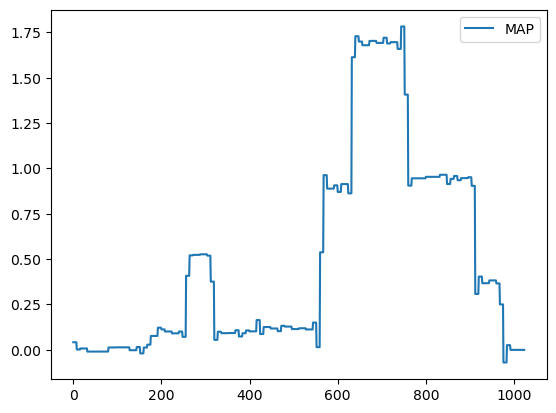

In [11]:
plt.plot(W(x_MAP), label='MAP')
plt.legend()

### 2.4 Sampling

We use the MALA sampler implemented in CUQIpy.

In [12]:
MALA_ref_sampler = MALA(X_given_Y, scale=4.42e-05, initial_point=np.zeros(d))

np.random.seed(0)
MALA_ref_sampler.warmup(N_b)  # warmup of sampler -- NO TUNING OF SCALE
MALA_ref_sampler.sample(N_po*th)
samples_ref = MALA_ref_sampler.get_samples().burnthin(N_b, th) # getting samples and removing burn-in

Sample: 100%|██████████| 250000/250000 [36:17<00:00, 114.82it/s, acc rate: 71.49%] 


We visually assess the convergence of the chain by plotting some sample traces. Moreover, we compute the effective sample size (ESS) for the components.

Selecting 5 randomly chosen variables


array([[<Axes: title={'center': 'X47'}>, <Axes: title={'center': 'X47'}>],
       [<Axes: title={'center': 'X342'}>,
        <Axes: title={'center': 'X342'}>],
       [<Axes: title={'center': 'X362'}>,
        <Axes: title={'center': 'X362'}>],
       [<Axes: title={'center': 'X604'}>,
        <Axes: title={'center': 'X604'}>],
       [<Axes: title={'center': 'X992'}>,
        <Axes: title={'center': 'X992'}>]], dtype=object)

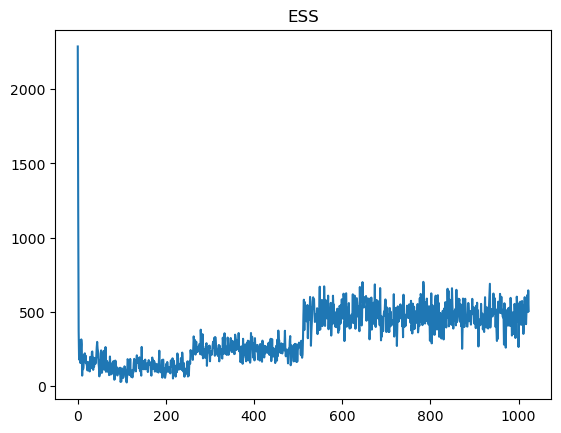

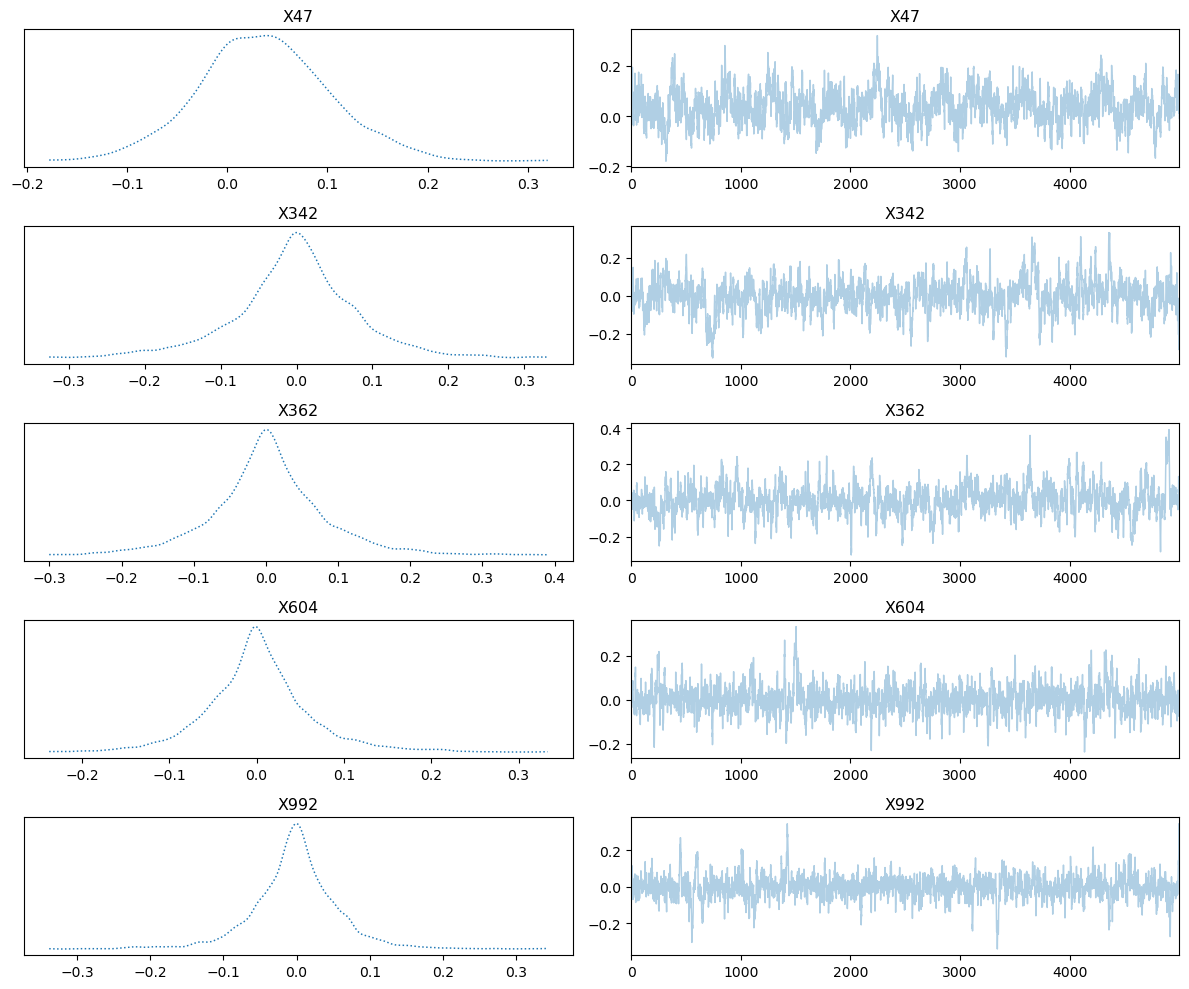

In [13]:
plt.plot(samples_ref.compute_ess())
plt.title('ESS')

samples_ref.plot_trace()

We note that the chains seem to have converged.

## 3. Dimension reduction

We now construct and sample an approximated, dimension-reduced, posterior density.

### 3.1 General procedure

We construct the approximate posterior by replacing the likelihood function by the ridge approximation 
$$
\tilde\pi(y|x_\mathcal{I}) = \left( \int_{\mathbb{R}_{\mathcal{I}^c}} \sqrt{\pi(y|x_\mathcal{I}, x_{\mathcal{I}^c})} \mathrm{d}x_{\mathcal{I}^c} \right)^2.
$$
Here $x_\mathcal{I}\in\mathbb{R}^r$ ($r\ll d$) are the selected coordinates, and $x_{\mathcal{I}^c}\in\mathbb{R}^{d-r}$ are the not selected coordinates. The splitting is defined by the index set of selected coordinates $\mathcal{I}\subset\{1,2,\dots,d\}$.

Therefore, the approximate posterior reads
$$
\tilde \pi(x|y) \propto \tilde\pi(y|x_\mathcal{I}) \pi(x_\mathcal{I}) \pi(x_{\mathcal{I}^c}),
$$
where the splitting of the prior is possible due to its product-form.

The general procedure to obtain samples from $\tilde \pi(x|y)$ is comprised of three main steps: \
&emsp; 1) Identify index set $\mathcal{I}$ by estimating the _diagnostic_ (see next section). \
&emsp; 2) Sample the approximate marginal posterior 
$
\tilde \pi(x_\mathcal{I}|y) \propto \tilde\pi(y|x_\mathcal{I}) \pi(x_\mathcal{I}).
$ \
&emsp; 3) Sample the not selected coordinates from $\pi(x_{\mathcal{I}^c})$. \
&emsp; 4) Combine samples from  steps 2) and 3).

### 3.2 Estimation of the diagnostic

The diagnostic $h\in\mathbb{R}^d$ serves as indicator for the most important coordinates which are essential for the update from the prior to the posterior. In this regard, the indices of the largest components in $h$ correspond to the most important coordinates which should be included in $x_\mathcal{I}$.

According to [1], we can compute a Monte Carlo estimate of the diagnostic with samples $\{x^{(j)}\}_{j=1}^N \sim \pi(x|y)$ from the posterior as 
$$
\tilde{h}_i = \frac{1}{N} \frac{1}{\delta_i^2} \sum_j^N (\frac{\partial}{\partial x_i} \log \pi(y|x^{(j)}))^2.
$$
For our problem, we have
$$
\nabla \log \pi(y|x) = \lambda A^T (y - Ax).
$$

In [14]:
grad_log_like = lambda x: lam * A_adj(y-A(x))
h_MC = lambda samples_array: 1/samples_array.shape[1] * 1/delta**2 * np.sum( np.apply_along_axis(grad_log_like, axis=0, arr=samples_array)**2, axis=1)

Obviously, no samples from the posterior are available (yet). Therefore, we have to estimate the diagnostic using samples from approximations to the posterior. We present two viable choices here: We use samples from a Gaussian approximation at the MAP (often called _Laplace approximation_) and from the prior.

In the following, we first sample from the Gaussian approximation at the MAP. Given a posterior density $\pi(x|y)$ the Gaussian approximation is given by $\tilde x|y \sim \mathcal{N}(\tilde \mu, \tilde \Sigma)$. Here the approximate posterior mean $\tilde \mu$ and covariance $\tilde \Sigma$ are given by
$$
\tilde \mu := x_\mathrm{MAP}
$$
and
$$
\tilde \Sigma := -(\nabla^2 \log \pi(x|y))^{-1}
$$

Using the posterior density with the smoothed Laplace distribution, we have
$$
\tilde \Sigma_\varepsilon := -(\nabla^2 \log \pi_\varepsilon(x|y))^{-1} = (\lambda A^T A + L_\varepsilon(x_{\mathrm{MAP}}))^{-1} 
$$
where $L_\varepsilon(x_{\mathrm{MAP}})$ is a diagonal matrix with entries
$$
[L_\varepsilon(x_{\mathrm{MAP}})]_{ii} = \frac{\varepsilon \delta_i}{\left(\sqrt{x_{\mathrm{MAP},i}^2+\varepsilon}\right)^{3}}
$$ 
on the main diagonal.

Given an inverse covariance (precision) of the form as above, we can use linear RTO for sampling which is implemented in the accompanying ´utils.py´ script. For more information on linear RTO see 

[2] _Bardsley, Johnathan M. “MCMC-Based Image Reconstruction with Uncertainty Quantification.” SIAM Journal on Scientific Computing 34, no. 3 (2012): A1316–32. https://doi.org/10.1137/11085760X._ \
[3] _Bardsley, Johnathan M., Antti Solonen, Heikki Haario, and Marko Laine. “Randomize-Then-Optimize: A Method for Sampling from Posterior Distributions in Nonlinear Inverse Problems.” SIAM Journal on Scientific Computing 36, no. 4 (2014): A1895–1910. https://doi.org/10.1137/140964023._

The advantage of RTO is that we can use our linear operator $A=GW$ and its adjoint and do not need to compute the corresponding matrices explicitly. This is particularly useful in high-dimensional problems. (In our relatively small problem, computing the matrices and sampling via a Cholesky factorization of $\tilde \Sigma_\varepsilon$ would also be feasible.)

**Note** that for the computation of $\tilde \Sigma_\varepsilon$, we chose $\varepsilon=2/\max(\delta)^2$ based on the heuristic rule from [1].

In [15]:
eps = 2/np.max(delta)**2 # use heuristic rule for smoothing parameter
D = delta*eps * 1/(np.sqrt(x_MAP**2 + eps)**3) # main diagonal of diagonal matrix D_\varepsilon

samples_Gauss = linear_RTO(A, A_adj, lam, D, x_MAP, N_po)

 it 5000, istop 2

We now sample from the prior to obtain an alternative estimate of the diagnostic $h$. 

In [16]:
samples_prior = fast_Laplace(delta, N_po)

Having samples from the Gaussian approximation at the MAP and the prior, we can now estimate $h$. For comparison, we also compute a reference solution that we obtain via our reference samples from section 2.3. Note that since we used CUQIpy to compute the reference samples, the numpy array of samples is stored in `samples_ref.samples`.

In [17]:
h_MC_Gauss = h_MC(samples_Gauss)
h_MC_prior = h_MC(samples_prior)
h_MC_ref = h_MC(samples_ref.samples)

We can now plot the different estimates of the diagnostic. For more information and how the diagnostic can be used to compute an upper bound on the Hellinger distance between the exact and the approximate posterior see [1].

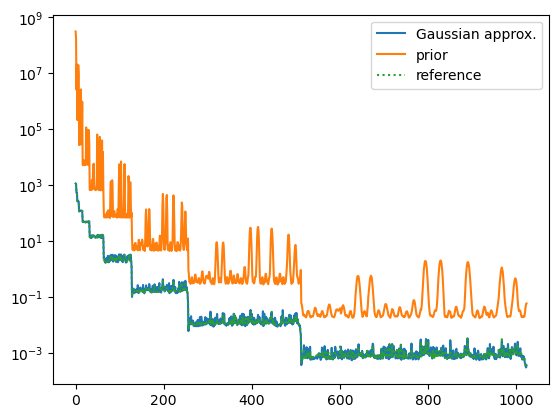

In [18]:
plt.semilogy(h_MC_Gauss, label='Gaussian approx.')
plt.semilogy(h_MC_prior, label='prior')
plt.semilogy(h_MC_ref, label='reference', ls=':')
plt.legend()

We see that the Gaussian approximation at the MAP provides visually a fair approximation to the reference, and we will use this estimate to select the coordinates in the next section.

### 3.3 Sampling the dimension-reduced posterior 

To construct the approximate posterior, we first select the most important coordinates using our approximated diagnostic based on the MAP estimate. To this end, we sort the diagnostic in ascending order and then select the first `r` coordinates. 

In [19]:
I = np.argsort(h_MC_Gauss)[-r:]
I_c = np.setdiff1d(np.arange(d), I)

We now construct the approximate posterior. As we have seen in section 3.1, this is done by replacing the likelihood function by the ridge approximation 
$$
\tilde\pi(y|x_\mathcal{I}) = \left( \int_{\mathbb{R}_{\mathcal{I}^c}} \sqrt{\pi(y|x_\mathcal{I}, x_{\mathcal{I}^c})} \mathrm{d}x_{\mathcal{I}^c} \right)^2
$$

However, since this integral is not tractable, we take the approximation
$$
\tilde\pi(y|x_\mathcal{I}) \propto \pi(y|x_\mathcal{I}, x_{\mathcal{I}^c}=0),
$$
i.e., we set the not selected coordiantes in the likelihood to zero.

In [20]:
def A_red(x_I):
    x = np.zeros(d)
    x[I] = x_I
    return A(x)
A_adj_red = lambda y: A_adj(y)[I]
A_red_cuqi = LinearModel(A_red, adjoint=A_adj_red, range_geometry=d, domain_geometry=r)

X_red = SmoothedLaplace(np.zeros(r), 1/delta[I], beta=1e-8)
Y_red = Gaussian(A_red_cuqi@X_red, 1/lam*np.eye(d))
joint_XY_red = JointDistribution(X_red, Y_red)
X_given_Y_red = joint_XY_red(Y_red=y) # marginal posterior 

We now sample the approximate marginal posterior $\tilde \pi(x_\mathcal{I}|y)$. To this end, we use CUQIpy's implementation of MALA.

In [21]:
MALA_red_sampler = MALA(X_given_Y_red, scale=3.35e-04, initial_point=np.zeros(r))

np.random.seed(1)
MALA_red_sampler.warmup(N_b)  # warmup of sampler -- NO TUNING OF SCALE
MALA_red_sampler.sample(N_po*th) 
samples_red = MALA_red_sampler.get_samples().burnthin(N_b, th) # getting samples and removing burn-in

Sample: 100%|██████████| 250000/250000 [20:46<00:00, 200.62it/s, acc rate: 85.21%]


Again, we check same sample traces to virtually assess the convergence of the chain. Also, we plot the ESS for all components again.

Selecting 5 randomly chosen variables


array([[<Axes: title={'center': 'X_red25'}>,
        <Axes: title={'center': 'X_red25'}>],
       [<Axes: title={'center': 'X_red35'}>,
        <Axes: title={'center': 'X_red35'}>],
       [<Axes: title={'center': 'X_red41'}>,
        <Axes: title={'center': 'X_red41'}>],
       [<Axes: title={'center': 'X_red66'}>,
        <Axes: title={'center': 'X_red66'}>],
       [<Axes: title={'center': 'X_red87'}>,
        <Axes: title={'center': 'X_red87'}>]], dtype=object)

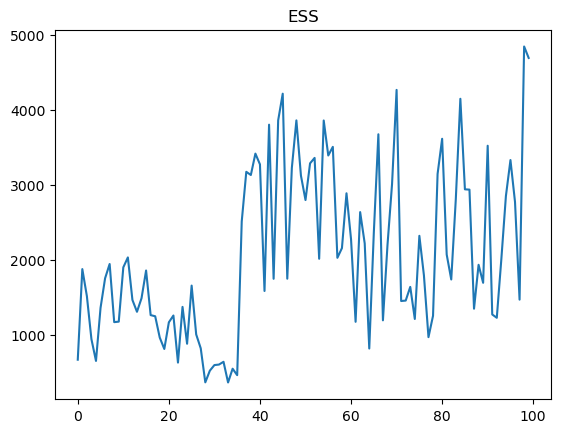

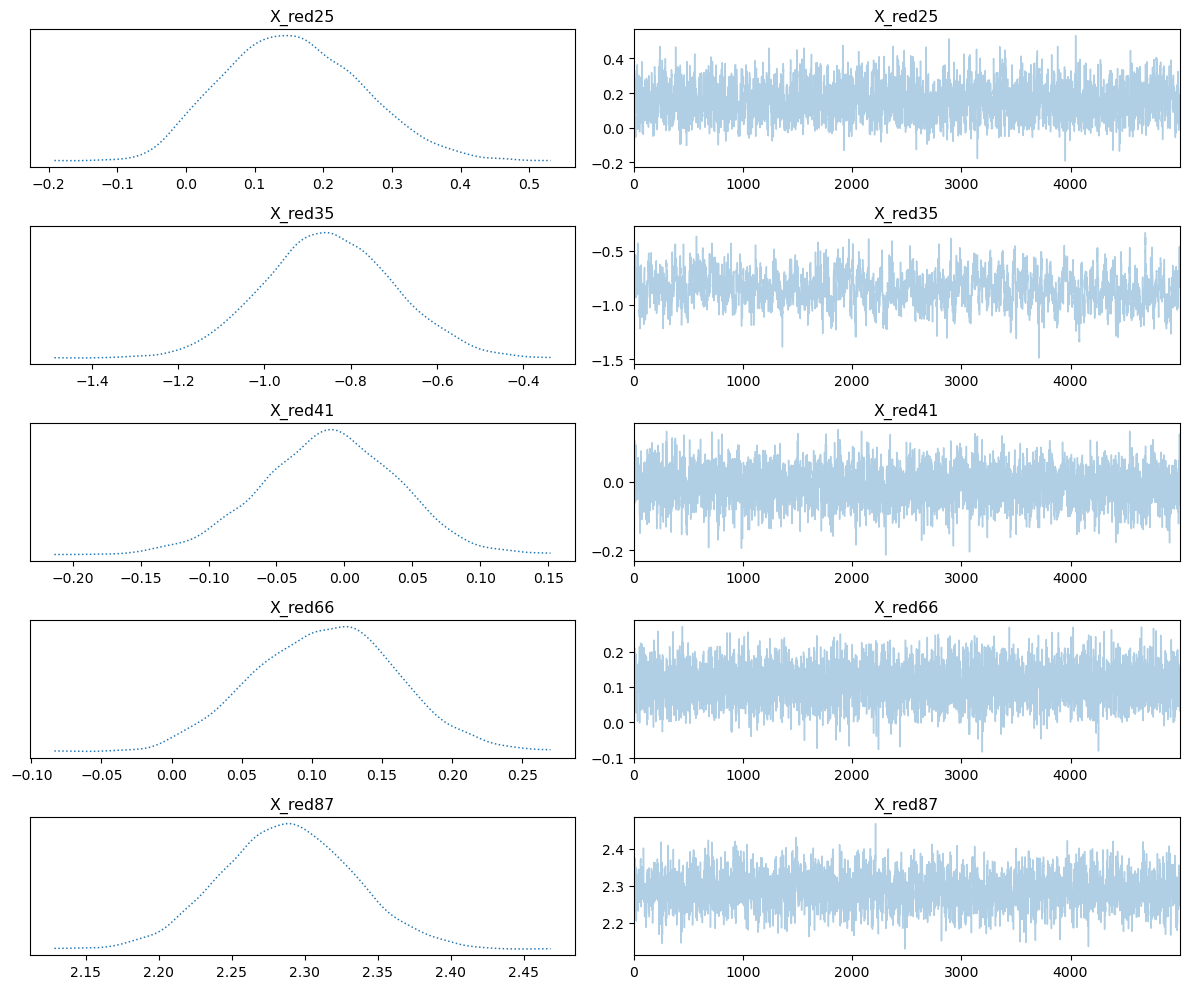

In [22]:
plt.plot(samples_red.compute_ess())
plt.title('ESS')

samples_red.plot_trace()

 We note that we obtain in general significantly larger ESS than with the reference sampling since we reduced the sampling dimension from 1024 to 100.

We now sample the not selected coordinates from the prior. This can be done in closed form, and we use an implementation for drawing samples in parallel from a product-form Laplace prior (`fast_Laplace`) which can be found in the ´utils.py´ script. Subsequently, we combine the samples of the selected and not selected coordinates.

In [23]:
samples_appr = np.zeros((d, N_po))
samples_appr[I_c] = fast_Laplace(delta[I_c], N_po)
samples_appr[I] = samples_red.samples

Now we transform our approximate and reference samples which we obtained in coefficience space to the signal space and make a plot of the posterior mean and the 95% credibility interval (CI) for comparison.

In [ ]:
# transform to signal space
samples_appr_signal = samples.Samples(np.apply_along_axis(func1d=W, arr=samples_appr, axis=0))
samples_ref_signal = samples.Samples(np.apply_along_axis(func1d=W, arr=samples_ref.samples, axis=0))

Text(0.5, 1.0, 'Reference posterior')

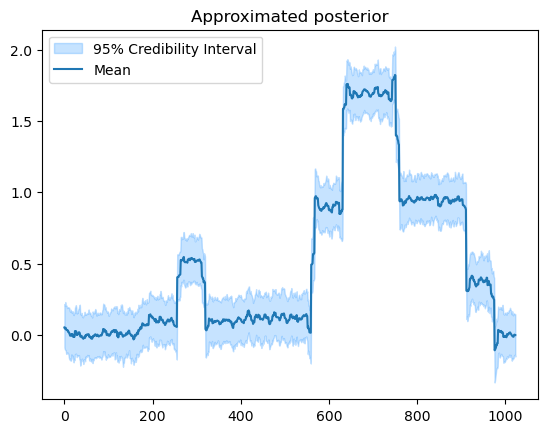

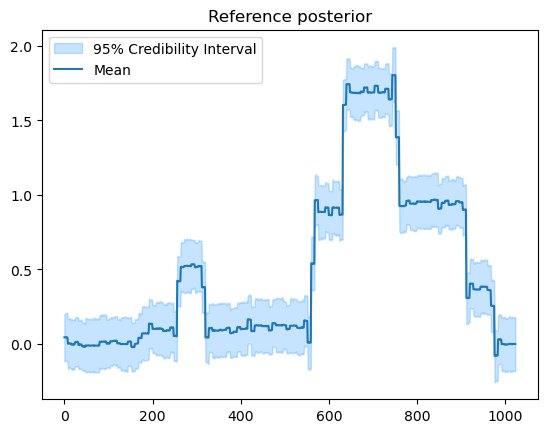

In [25]:
# comparison of reference and approximated posterior
plt.figure()
samples_ref_signal.plot_ci()
plt.title('Approximated posterior')
plt.figure()
samples_appr_signal.plot_ci()
plt.title('Reference posterior')

## 4. Conclusion 

The CCS method is a viable dimension reduction technique for Bayesian inverse problems with product-form Laplace prior (in fact, it is also applicable to problems with exponential priors).

The selection of coordinates is performed based on a diagnostic vector which can also be used to compute an upper bound on the Hellinger distance between the exact and approximated posterior (not shown in this notebook).
Although the computation of the diagnostic requires the posterior density, feasible estimates can be obtained by using the prior or a Gaussian approximation at the MAP estimate instead.

The CCS method is suitable for problems in signal reconstruction. 
This is because many signals can be represented in a sparse manner by a wavelet basis and a suitable prior on the wavelet coefficients is a product-form Laplace prior.
In this notebook, we have demonstrated the applicability of the CCS for such a problem.
In particular, we have obtained a feasible posterior approximation of a 1024-dimensional signal, although we have reduced the dimension for the main sampling step to 100 dimensions.

An alternative and even more powerful method for posterior with linear-Gaussian likelihoods and product-form Laplace priors is presented in the following work

[4] *Flock, Rafael, Yiqiu Dong, Felipe Uribe, and Olivier Zahm. “Continuous Gaussian Mixture Solution for Linear Bayesian Inversion with Application to Laplace Priors.” arXiv, 2024. http://arxiv.org/abs/2408.16594.*